# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022

This is a code supporting the corresponding paper.

Packages import:

In [3]:
import os
import numpy as np

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

import cv2
import SimpleITK as sitk

from skimage import exposure
from skimage import img_as_float
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pandas as pd

plt.style.use("ggplot")

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from scipy.ndimage import zoom

Using TensorFlow backend.
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\E.Lavrova\.conda\envs\lisa

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'                        
import tensorflow as tf
import keras.backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## 1. Loading the models

In [10]:
im_side = 512

In [7]:
from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
import mrcnn.model as modellib
from matplotlib.patches import Rectangle

In [8]:
class PredictionConfig(Config):
    NAME = "plaque_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [36]:
cfg = PredictionConfig()

model_simple = MaskRCNN(mode='inference', model_dir='../res', config=cfg)
model_simple.load_weights("../res/mask-rcnn_simple.h5", by_name=True)

model_aug = MaskRCNN(mode='inference', model_dir='../res', config=cfg)
model_aug.load_weights("../res/mask-rcnn_aug.h5", by_name=True)

In [60]:
def detect_ca(img_name, model, resize = False):
    
    dcm = pydicom.read_file(img_name, force = True)
    dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    img = dcm.pixel_array
    img_min = np.min(img)
    img_max = np.max(img)
    img_norm = ((img - img_min)/(img_max - img_min)*255).astype(np.uint8)
    
    dim = img_norm.shape
    
    img_ch = np.zeros((im_side, im_side, 3), dtype = np.uint8)
    
    if resize:
        img_res = cv2.resize(img_norm.copy(), dsize=(im_side, im_side), interpolation=cv2.INTER_CUBIC)
        img_ch = np.dstack((img_res, img_res, img_res))
    else:
        img_ch = np.dstack((img_norm[8:-8, 8:-8], img_norm[8:-8, 8:-8], img_norm[8:-8, 8:-8]))

    scaled_img = mold_image(img_ch, cfg)
    sample = expand_dims(scaled_img, 0)
    yhat = model.detect(sample, verbose=0)[0]
    
    ca_mask = np.zeros((im_side, im_side), dtype=np.uint8)
    
    for i in range (0, yhat['masks'].shape[2]):
        ca_mask+=yhat['masks'][..., i]
        
    if resize:
        ca_mask = cv2.resize(ca_mask, dsize=(dim[0], dim[1]), interpolation=cv2.INTER_CUBIC)
        
    return ca_mask

## 2. CA probability maps calculation

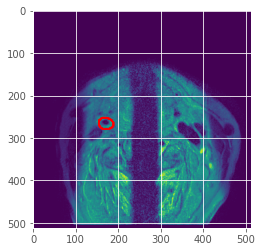

In [61]:
filename = "C:/Users/E.Lavrova/Documents/plaq-u-net/data/MUMC079/T1w_SER_1401_sl0006.dcm"

a = detect_ca(filename, model_simple)
b = path2array(filename)[8:-8,8:-8]

plt.imshow(b)
plt.contour(a, colors='r')
plt.show()

### 2.1. Test set

Getting patient names from the test set (from training script):

In [69]:
sub_names_test = ['AMC012', 'AMC006', 'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038',
                  'MUMC093', 'MUMC107', 'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 
                  'MUMC059', 'MUMC080', 'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']

Calculating CA probability maps and saving to the results folder:

In [49]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1w/mask-rcnn_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:

        vessels_pred_simple = detect_ca(sub_img_name, model_simple)
        vessels_pred_aug = detect_ca(sub_img_name, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_aug)

C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [72]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T2w/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T2w/mask-rcnn_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T2W_*.dcm')
    
    for sub_img_name in sub_img_names:

        vessels_pred_simple = detect_ca(sub_img_name, model_simple)
        vessels_pred_aug = detect_ca(sub_img_name, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_aug)

C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [73]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/T1wCE/mask-rcnn_simple/'
results_dir_aug = '../res/maps/T1wCE/mask-rcnn_aug/'

for sub_name in sub_names_test:
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W-contrast_*.dcm')
    
    for sub_img_name in sub_img_names:

        vessels_pred_simple = detect_ca(sub_img_name, model_simple)
        vessels_pred_aug = detect_ca(sub_img_name, model_aug)
        
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-10:-4] + '.npy', 
                vessels_pred_aug)

C:\Users\E.Lavrova\.conda\envs\lisa_tf1\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


### 2.2 EMC

Patient names from EMC:

In [64]:
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 
                 'EMC015', 'EMC018', 'EMC020', 'EMC024', 'EMC027', 'EMC029', 'EMC031', 
                 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 'EMC042', 
                 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 
                 'EMC051', 'EMC052', 'EMC054', 'EMC055', 'EMC056', 'EMC057']

Calculating CA probability maps and saving to the results folder:

In [68]:
ds_dir = '../data/'
results_dir_simple = '../res/maps/mask-rcnn_simple/'
results_dir_aug = '../res/maps/mask-rcnn_aug/'

for sub_name in sub_names_emc:
    
    print (sub_name)
    
    sub_img_names = glob.glob(ds_dir+sub_name+'*/T1W_*.dcm')
    
    for sub_img_name in sub_img_names:
        
        vessels_pred_simple = detect_ca(sub_img_name, model_simple, resize = True)
        vessels_pred_aug = detect_ca(sub_img_name, model_aug, resize = True)       
       
        np.save(results_dir_simple + sub_name + '/' + sub_img_name.split(os.sep)[2][-17:-11] + '.npy', 
                vessels_pred_simple)
        np.save(results_dir_aug + sub_name + '/' + sub_img_name.split(os.sep)[2][-17:-11] + '.npy', 
                vessels_pred_aug)

EMC003
EMC004
EMC005
EMC007
EMC008
EMC009
EMC011
EMC015
EMC018
EMC020
EMC024
EMC027
EMC029
EMC031
EMC032
EMC034
EMC035
EMC036
EMC038
EMC041
EMC042
EMC043
EMC045
EMC046
EMC047
EMC048
EMC049
EMC050
EMC051
EMC052
EMC054
EMC055
EMC056
EMC057
